Importing Necesaary Libraries

In [5]:

import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import xgboost as xgb
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

Importing Dataset


In [6]:

import zipfile
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    file_list = zip_ref.namelist()
    csv_file = file_list[0]
    with zip_ref.open(csv_file) as file:
        df = pd.read_csv(file)
print(df.head())

              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


Preprocessing data

In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [8]:
df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [9]:
df.shape

(121273, 1)

In [10]:
df.isnull().sum()

,0
AEP_MW,0


EDA

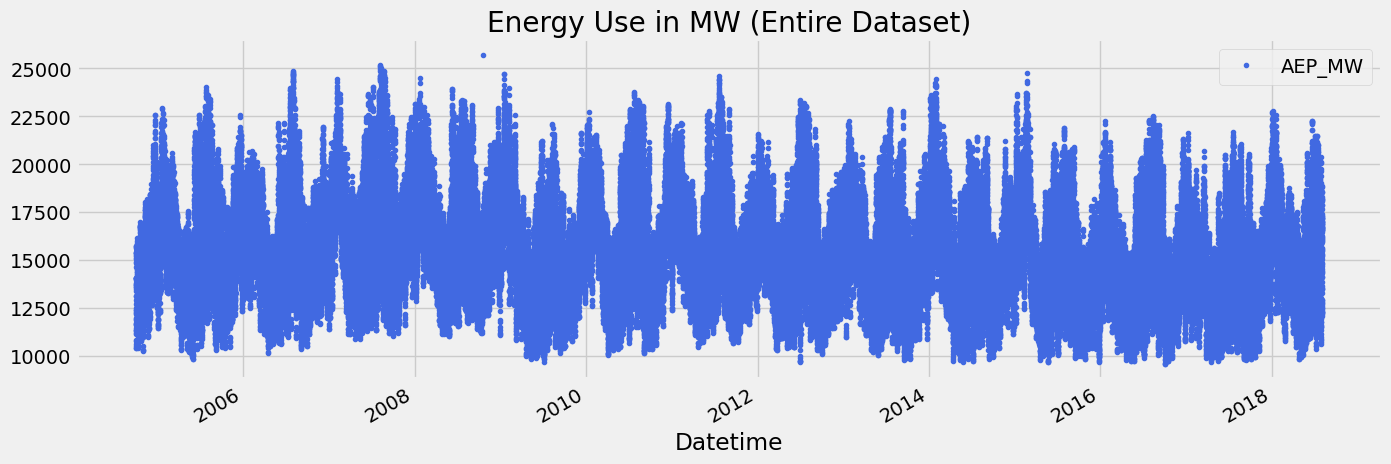

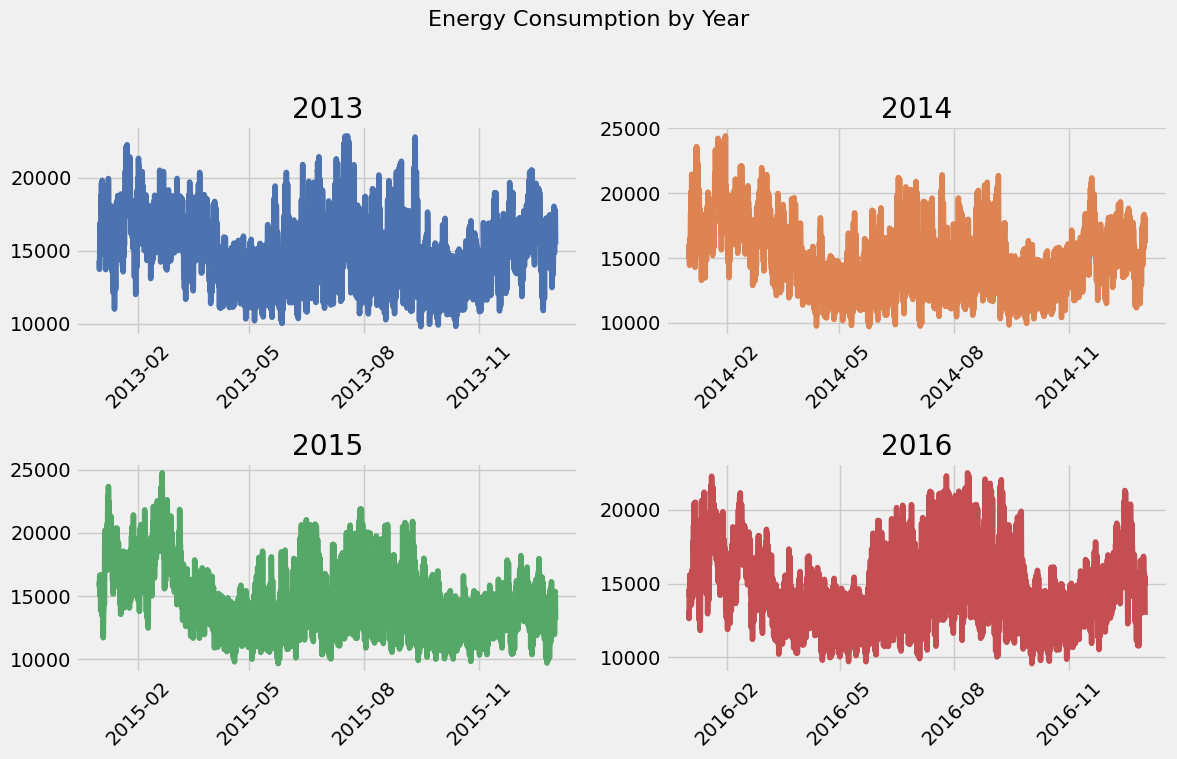

In [11]:
plt.style.use('fivethirtyeight')

df.plot(style='.',
        figsize=(15, 5),
        color='royalblue',
        title='Energy Use in MW (Entire Dataset)')
plt.show()

year_one = df.loc[(df.index >= '2013-01-01 01:00:00') & (df.index <= '2014-01-01 01:00:00')]
year_two = df.loc[(df.index >= '2014-01-01 01:00:00') & (df.index <= '2015-01-01 01:00:00')]
year_three = df.loc[(df.index >= '2015-01-01 01:00:00') & (df.index <= '2016-01-01 01:00:00')]
year_four = df.loc[(df.index >= '2016-01-01 01:00:00') & (df.index <= '2017-01-01 01:00:00')]
years = [year_one, year_two, year_three, year_four]
year_labels = ['2013', '2014', '2015', '2016']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Year', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('deep', 4)
for i, year in enumerate(years):
    # The original code was looking for a column named 'PJME_MW', which doesn't exist in your DataFrame.
    # Changing 'PJME_MW' to 'AEP_MW' which is the actual column name in your DataFrame.
    axes[i].plot(year.index, year['AEP_MW'], color=colors[i])
    axes[i].set_title(year_labels[i])
    axes[i].set

    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Setting x axis tick marks/intervals

    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

For an Particular Year

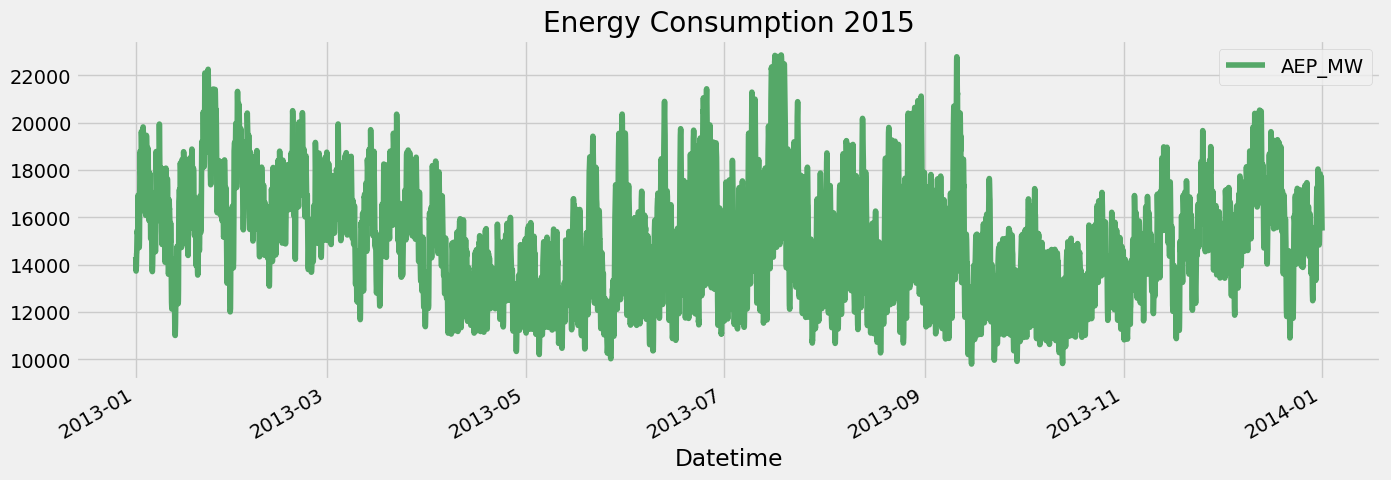

In [12]:

year_one.plot(figsize=(15, 5),
              title="Energy Consumption 2015",
              color=colors[2])
plt.show()

For an month(January)


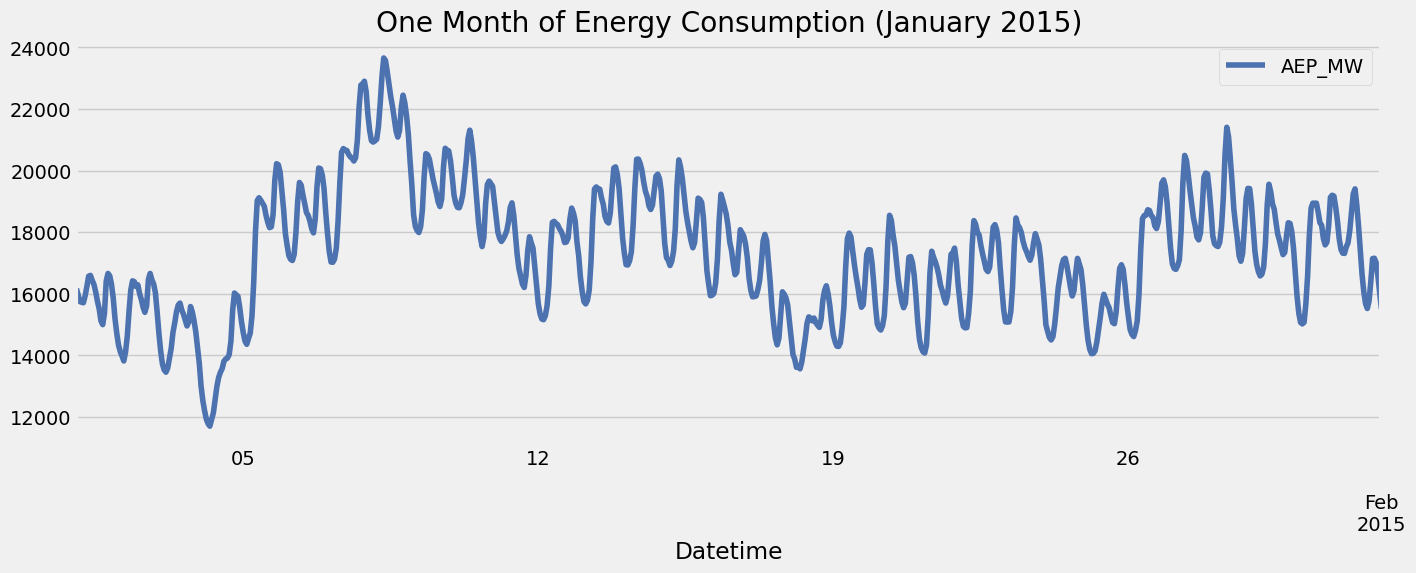

In [13]:

import matplotlib.dates as mdates  # Importing for date formatting on the x-axis


# Define month_one
month_one = df.loc[(df.index >= '2015-01-01 01:00:00') & (df.index < '2015-02-01 01:00:00')]

month_one.plot(figsize=(15, 5),
              title="One Month of Energy Consumption (January 2015)",
              color=colors[0])
plt.show()

At a glance, months do not appear to resemble one another in overall structure. Energy consumption appears to align more on a daily/weekly basis, we will dig deeper.

Weekly Info


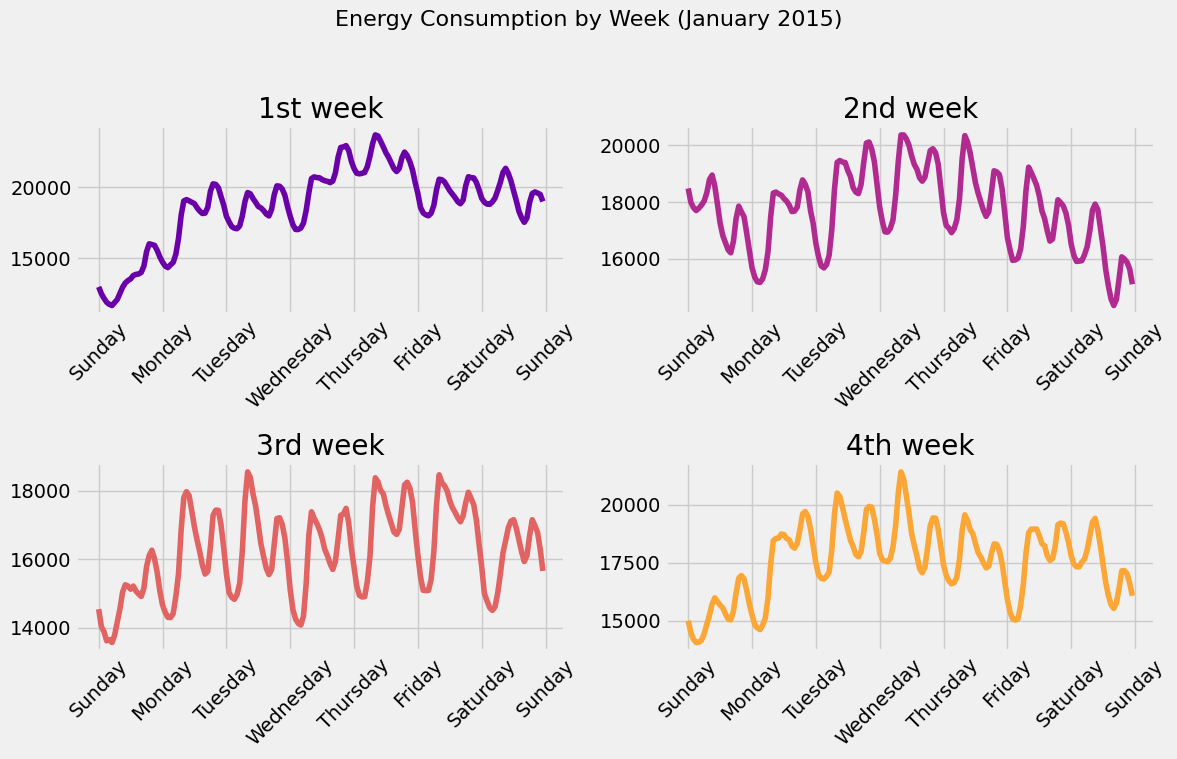

In [14]:
# Plotting Sunday - Saturday for each week
week_one = df.loc[(df.index >= '2015-01-04 00:00:00') & (df.index < '2015-01-11 00:00:00')]
week_two = df.loc[(df.index >= '2015-01-11 00:00:00') & (df.index < '2015-01-18 00:00:00')]
week_three = df.loc[(df.index >= '2015-01-18 00:00:00') & (df.index < '2015-01-25 00:00:00')]
week_four = df.loc[(df.index >= '2015-01-25 00:00:00') & (df.index < '2015-02-1 00:00:00')]

weeks = [week_one, week_two, week_three, week_four]
week_labels = ['1st week', '2nd week', '3rd week', '4th week']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Week (January 2015)', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('plasma', 4)

for i, week in enumerate(weeks):
    # The original code was looking for a column named 'PJME_MW', which doesn't exist in your DataFrame.
    # Changing 'PJME_MW' to 'AEP_MW' which is the actual column name in your DataFrame.
    axes[i].plot(week.index, week['AEP_MW'], color = colors[i])
    axes[i].set_title(week_labels[i])

    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Setting x axis tick marks/intervals
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%A')) # Format x axis to say day names
    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

Looking closely in 1 st week of January

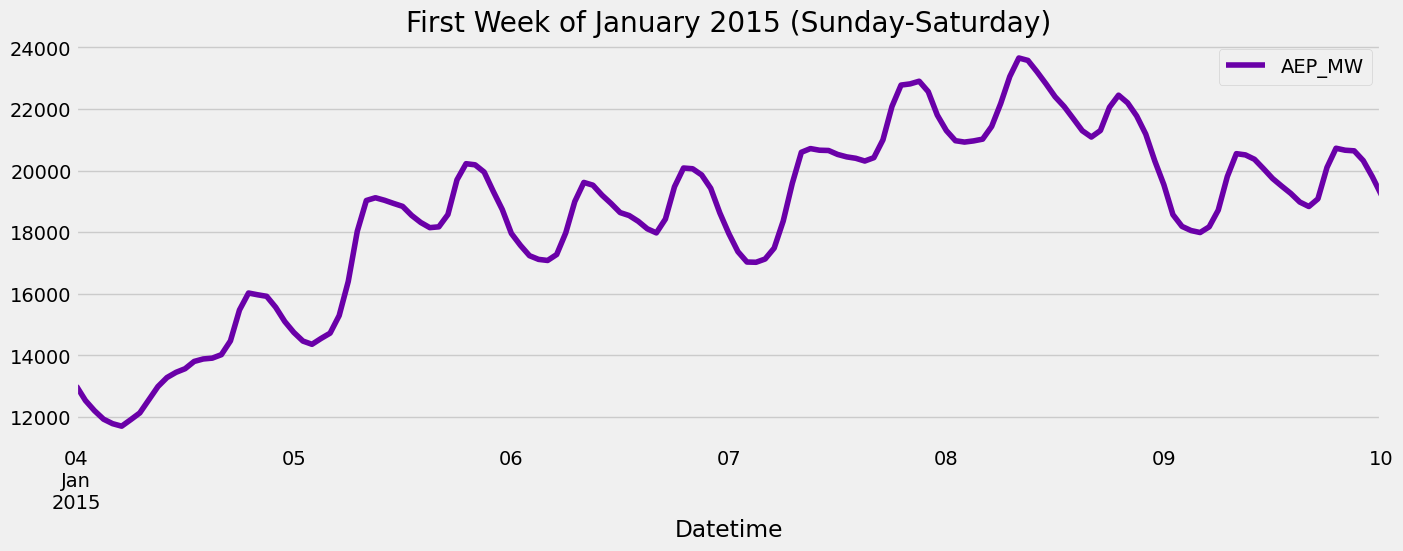

In [15]:

one_week = df.loc[(df.index >= '2015-01-04') & (df.index <= '2015-01-10')]

# Plotting one week of data
ax = one_week.plot(figsize=(15, 5),
              title="First Week of January 2015 (Sunday-Saturday)",
              color=colors[0])


plt.show()

Energy usage appears to increase throughout the week from Sunday-Friday, then dropping off on Saturday. Days appears to retain the same pattern regardless of the day of the week.

In [16]:
# Plotting Sunday - Saturday for each week
week_one = df.loc[(df.index >= '2015-01-04 00:00:00') & (df.index < '2015-01-11 00:00:00')]
week_two = df.loc[(df.index >= '2015-01-11 00:00:00') & (df.index < '2015-01-18 00:00:00')]
week_three = df.loc[(df.index >= '2015-01-18 00:00:00') & (df.index < '2015-01-25 00:00:00')]
week_four = df.loc[(df.index >= '2015-01-25 00:00:00') & (df.index < '2015-02-1 00:00:00')]

weeks = [week_one, week_two, week_three, week_four]
week_labels = ['1st week', '2nd week', '3rd week', '4th week']


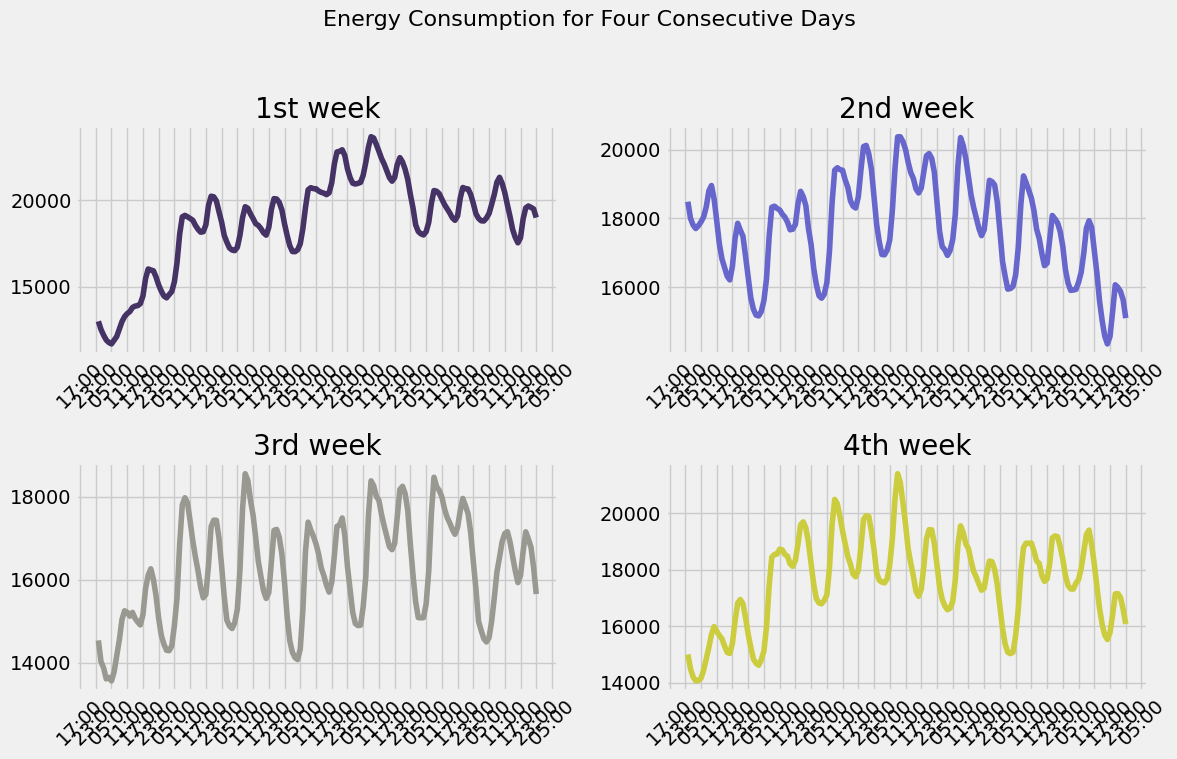

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption for Four Consecutive Days', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('gist_stern', 4)

# Assuming 'weeks' and 'week_labels' are defined as in the previous cell
for i, week in enumerate(weeks):  # Changed 'days' to 'weeks' to iterate through the weeks

    axes[i].plot(week.index, week['AEP_MW'], color=colors[i])
    axes[i].set_title(week_labels[i])  # Using 'week_labels'

    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Setting x axis tick marks/intervals
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Show hours and minutes


    axes[i].tick_params(axis='x', rotation=45)  # Optionally rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

While the range of energy consumed for a specific day varies signifigantly, each day largely retains the same general pattern of consumption. It is lowest during the night, hits a local maximum in the morning, and its global maximum towards the evening. This is not particularly surprising, if you were to guess at energy consumption for a day you would probably be pretty close, but is nice to find patterns within our data.

Splitting Data into Training and Testing Sets


In [19]:

def split_data(df, split_date='01-01-2015'):
    train = df.loc[df.index < split_date]
    test = df.loc[df.index >= split_date]
    return train, test

train, test = split_data(df)

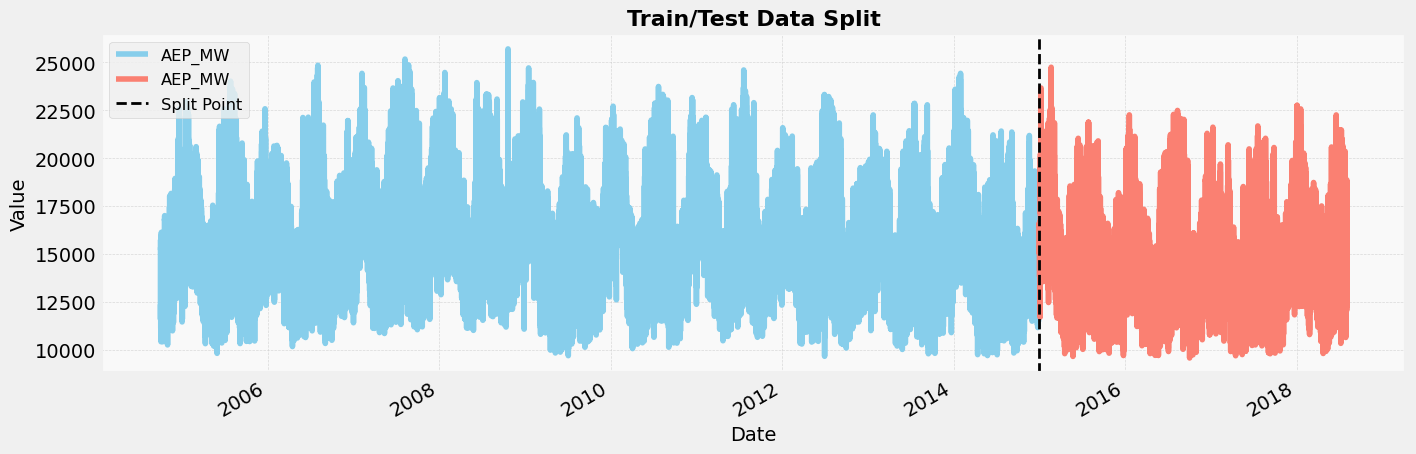

In [20]:
# Visualizing our train/test split
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, color='skyblue', label='Training Set')
test.plot(ax=ax, color='salmon', label='Test Set')

ax.axvline(pd.to_datetime('01-01-2015'), color='black', ls='--', lw=2, label='Split Point')

# Customization
ax.set_title('Train/Test Data Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.legend(fontsize='small', loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area

plt.show()

Feature Creation


In [21]:
import holidays

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return add_holidays(df)

def add_holidays(df, country='US'):
    df = df.copy()

    # Create an instance of the holiday class for the specified country
    holiday_list = holidays.CountryHoliday(country)

    # Make a new column with '0' for non-holidays and '1' for holidays
    df['holiday'] = df.index.map(lambda x: x in holiday_list).astype(int)

    return df

df_original = df.copy()
df = create_features(df)
df = add_holidays(df)

In [22]:
christmas = df.loc[df.index == '2015-12-25']
new_years = df.loc[df.index == '2016-01-01']
random_day = df.loc[df.index == '2016-01-02']
print('christmas',christmas['holiday'])
print('new years',new_years['holiday'])
print('non-holiday',random_day['holiday'])

christmas Datetime
2015-12-25    1
Name: holiday, dtype: int64
new years Datetime
2016-01-01    1
Name: holiday, dtype: int64
non-holiday Datetime
2016-01-02    0
Name: holiday, dtype: int64


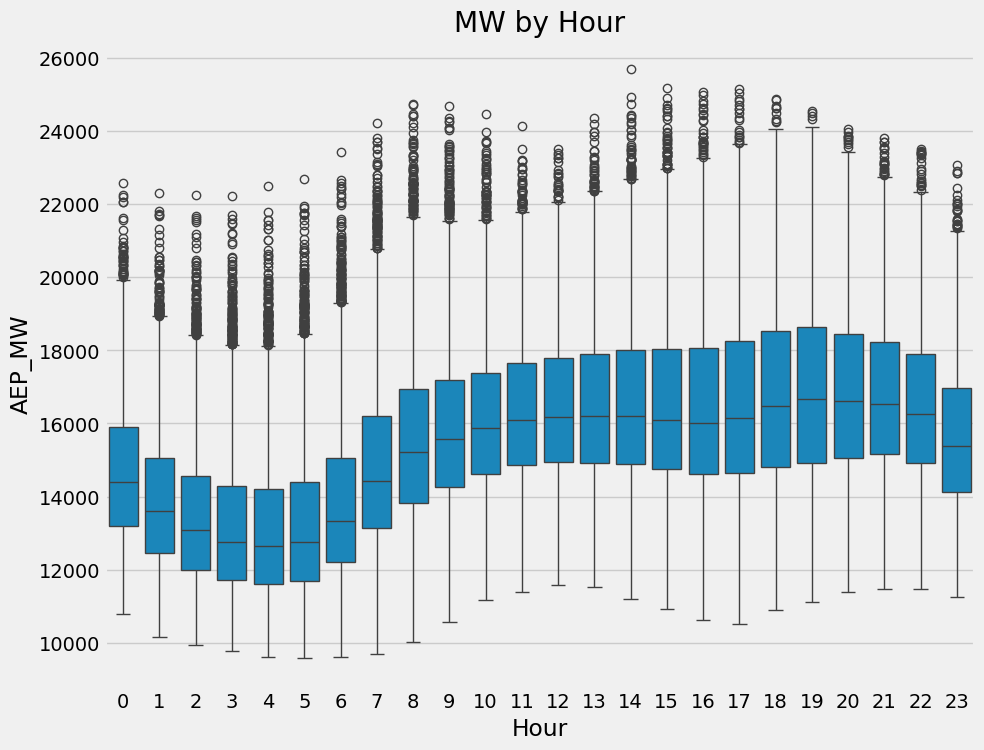

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distributions of each hour of the day
fig, ax = plt.subplots(figsize=(10, 8))

# Assuming 'AEP_MW' is the correct column representing energy consumption
sns.boxplot(data=df, x='hour', y='AEP_MW')  # Changed 'PJME_MW' to 'AEP_MW'

ax.set_title('MW by Hour')
ax.set_xlabel('Hour')
plt.show()

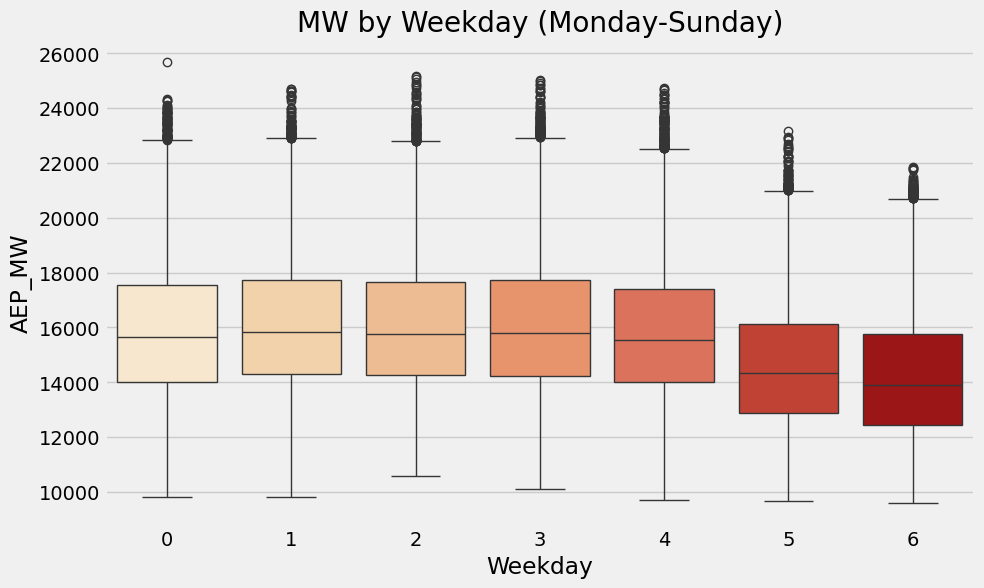

In [24]:

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df, x='dayofweek', y='AEP_MW', palette='OrRd')

ax.set_xlabel('Weekday')
ax.set_title('MW by Weekday (Monday-Sunday)')
plt.show()

ValueError: Could not interpret value `PJME_MW` for `y`. An entry with this name does not appear in `data`.

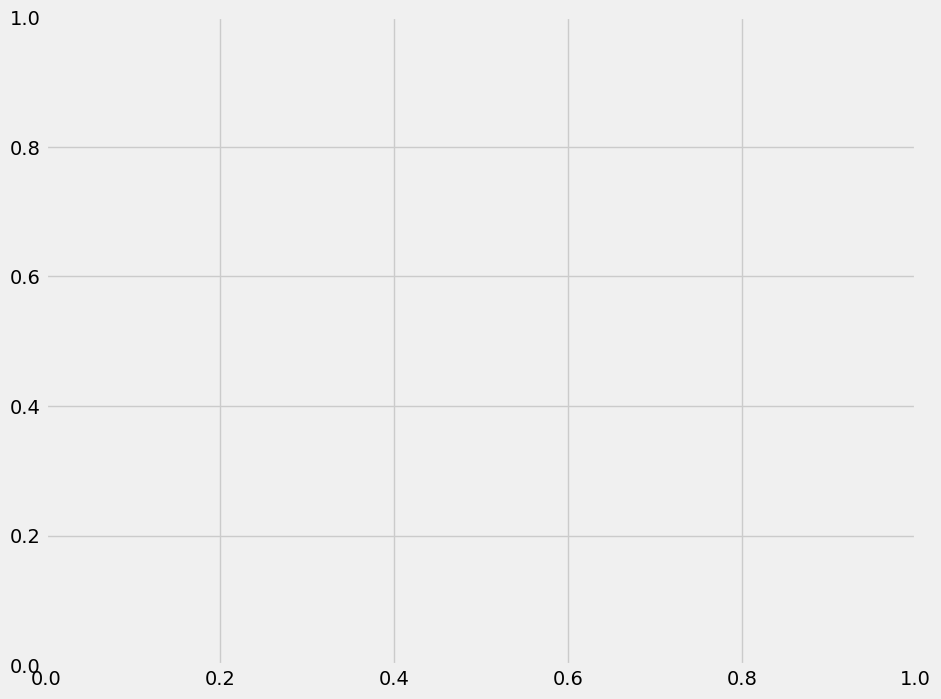

In [25]:
# Distributions of each month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
ax.set_xlabel('Month')
plt.show()

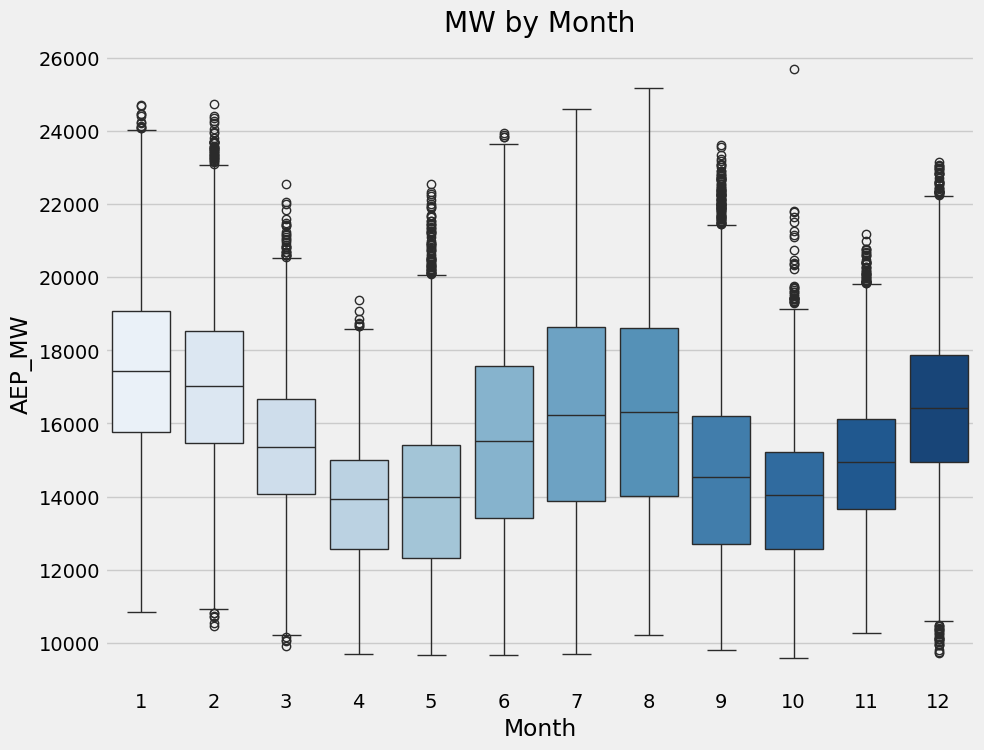

In [26]:
# Distributions of each month
fig, ax = plt.subplots(figsize=(10, 8))
# Changing 'PJME_MW' to 'AEP_MW' to match the column name in your DataFrame
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
ax.set_xlabel('Month')
plt.show()

Prepping our data for XGBoost

In [28]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'holiday', 'weekofyear', 'dayofmonth']
# Change TARGET to 'AEP_MW' to match the column name in your DataFrame
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [29]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1300,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:15793.26088	validation_1-rmse:14861.30012
[100]	validation_0-rmse:6033.87743	validation_1-rmse:5144.79203
[200]	validation_0-rmse:2702.84053	validation_1-rmse:2160.24010
[300]	validation_0-rmse:1752.22565	validation_1-rmse:1667.42354
[400]	validation_0-rmse:1508.33805	validation_1-rmse:1654.71020
[409]	validation_0-rmse:1496.37286	validation_1-rmse:1655.47623


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance

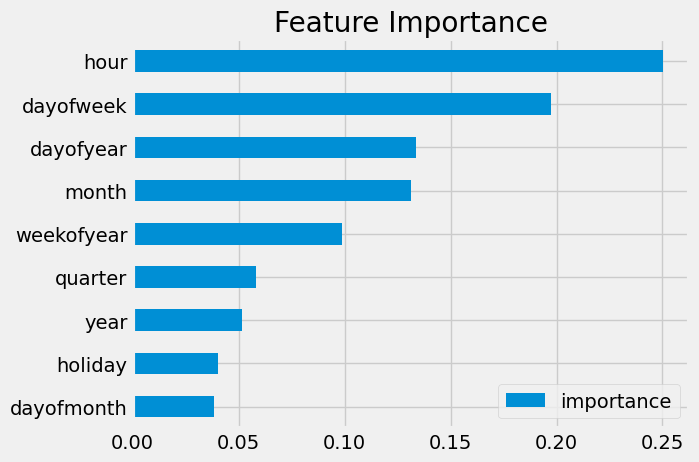

In [30]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

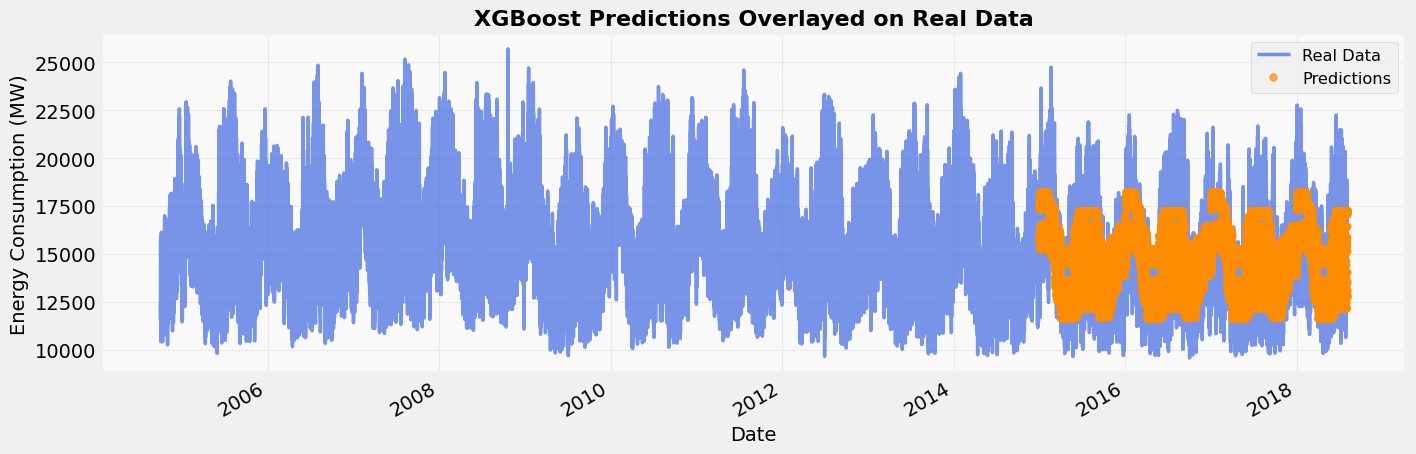

In [32]:
# Plotting real data
ax = df[['AEP_MW']].plot(figsize=(15, 5), linewidth=2.5, linestyle='-', color='royalblue', alpha=0.7)
# Plotting predictions
df['prediction'].plot(ax=ax, style='o', markersize=5, color='darkorange', alpha=0.7)

plt.legend(['Real Data', 'Predictions'], fontsize='small')
ax.set_title('XGBoost Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area

plt.show()

In [33]:
# Function for mape because sklearn does not provide one
def mape(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mae_score = mean_absolute_error(test['AEP_MW'], test['prediction']) # Change 'PJME_MW' to 'AEP_MW'
print(f'Mean Absolute Error Score on Test set: {mae_score:0.2f}')

Mean Absolute Error Score on Test set: 1329.89


In [37]:
rmse_score = sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')

RMSE Score on Test set: 1650.90


In [40]:
mape_score = mape(test['AEP_MW'], test['prediction'])
print(f'Mean Absolute Percentage Error Score on Test set: {mape_score:0.2f}')

Mean Absolute Percentage Error Score on Test set: 9.07


Using Facebook's Prophet to Forecast Energy Consumption

In [41]:
# Reset our dataframe and split again
df = df_original.copy()
train, test = split_data(df)

In [42]:
# Format data for prophet model using ds and y
prophet_train = train.reset_index() \
    .rename(columns={'Datetime':'ds','PJME_MW':'y'})
prophet_train.head()

,ds,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [44]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

# Create a dataframe with holiday, ds columns
df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
# The 'PJME_MW' column was renamed to 'AEP_MW' when creating 'holiday_df'.
# Therefore, drop 'AEP_MW' instead of 'PJME_MW'.
holiday_df = holiday_df.drop(['AEP_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2004-10-11 00:00:00,USFederalHoliday
1,2004-10-11 01:00:00,USFederalHoliday
2,2004-10-11 02:00:00,USFederalHoliday
3,2004-10-11 03:00:00,USFederalHoliday
4,2004-10-11 04:00:00,USFederalHoliday


In [45]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [47]:
# Format data for prophet model using ds and y
prophet_train = train.reset_index() \
    .rename(columns={'Datetime':'ds','AEP_MW':'y'}) # Changed PJME_MW to AEP_MW
prophet_train.head()

,ds,y
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [48]:
# Set up and train model
prophet_model = Prophet(holidays=holiday_df)
prophet_model.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp83kcy3ye/4v9yhjpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83kcy3ye/wwx_5j_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66105', 'data', 'file=/tmp/tmp83kcy3ye/4v9yhjpm.json', 'init=/tmp/tmp83kcy3ye/wwx_5j_c.json', 'output', 'file=/tmp/tmp83kcy3ye/prophet_modele6213mtp/prophet_model-20241129110555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
# Predict on training set with model
prophet_fcst = prophet_model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [50]:
prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,15055.845753,12542.973544,16335.340052,15055.845753,15055.845753,-1028.565711,-1028.565711,-1028.565711,-464.412508,...,603.466860,603.466860,603.466860,701.557473,701.557473,701.557473,0.0,0.0,0.0,14591.433245
1,2015-01-01 01:00:00,15055.830730,11856.303854,15837.891964,15055.830730,15055.830730,-1028.565711,-1028.565711,-1028.565711,-1246.745976,...,605.915738,605.915738,605.915738,702.606810,702.606810,702.606810,0.0,0.0,0.0,13809.084754
2,2015-01-01 02:00:00,15055.815708,11208.944685,15196.025699,15055.815708,15055.815708,-1028.565711,-1028.565711,-1028.565711,-1840.820960,...,607.488624,607.488624,607.488624,703.681456,703.681456,703.681456,0.0,0.0,0.0,13214.994747
3,2015-01-01 03:00:00,15055.800685,10867.755748,14833.190487,15055.800685,15055.800685,-1028.565711,-1028.565711,-1028.565711,-2181.557206,...,608.186266,608.186266,608.186266,704.781410,704.781410,704.781410,0.0,0.0,0.0,12874.243479
4,2015-01-01 04:00:00,15055.785662,10891.381410,14879.404118,15055.785662,15055.785662,-1028.565711,-1028.565711,-1028.565711,-2219.534621,...,608.020963,608.020963,608.020963,705.906668,705.906668,705.906668,0.0,0.0,0.0,12836.251041


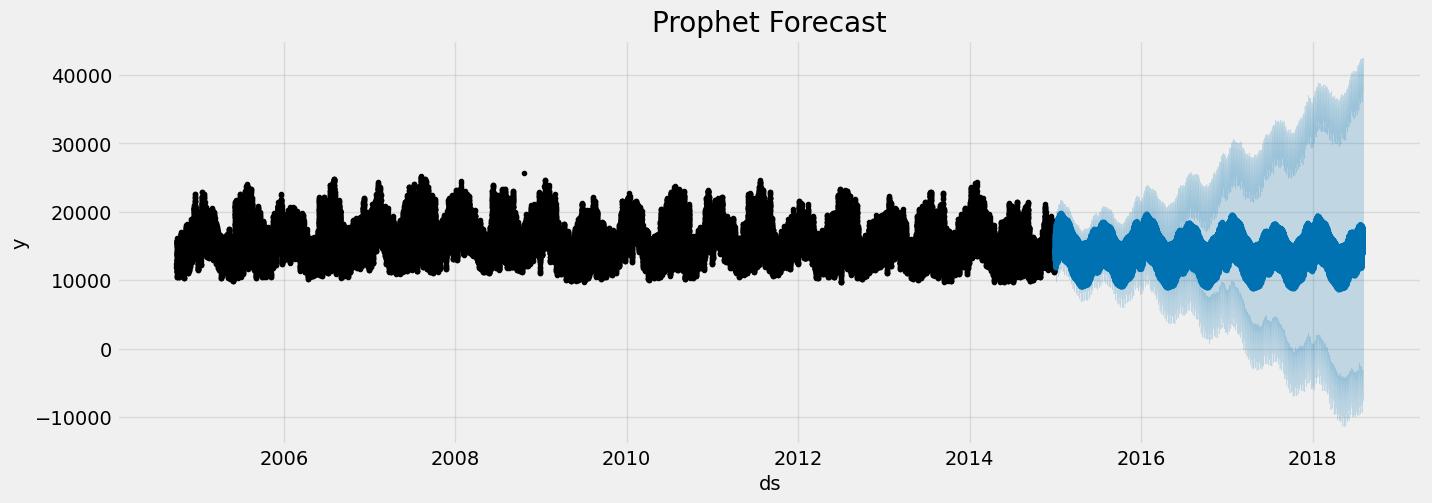

In [51]:
# Plot the forecast
f, ax = plt.subplots(1)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_model.plot(prophet_fcst,ax=ax)
plt.show()

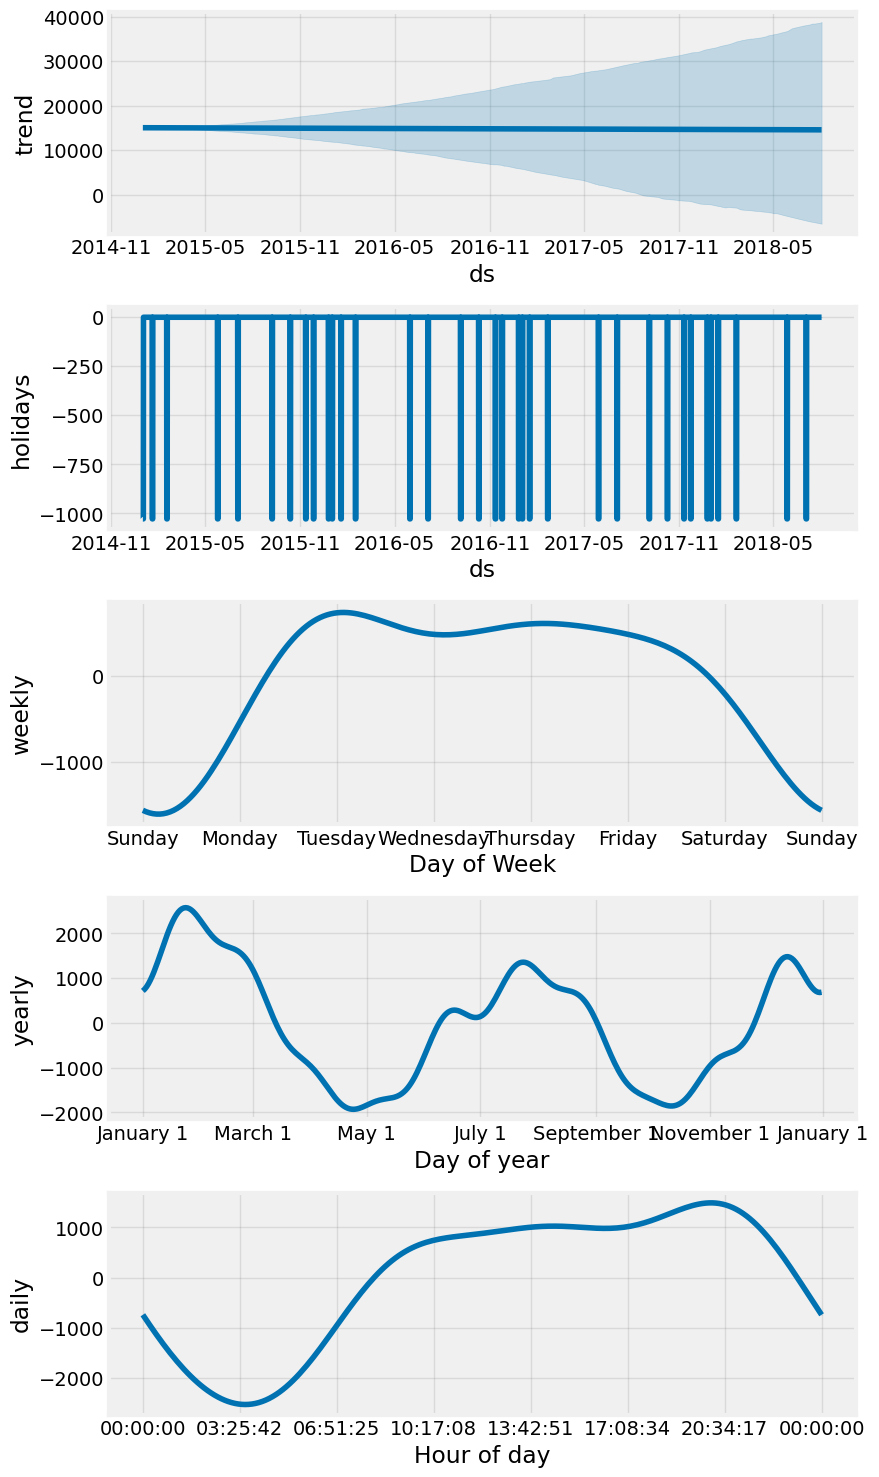

In [52]:
# Plotting the components of the model

warnings.simplefilter("ignore", FutureWarning)
fig = prophet_model.plot_components(prophet_fcst)

Comparing Forecast to Actual Values

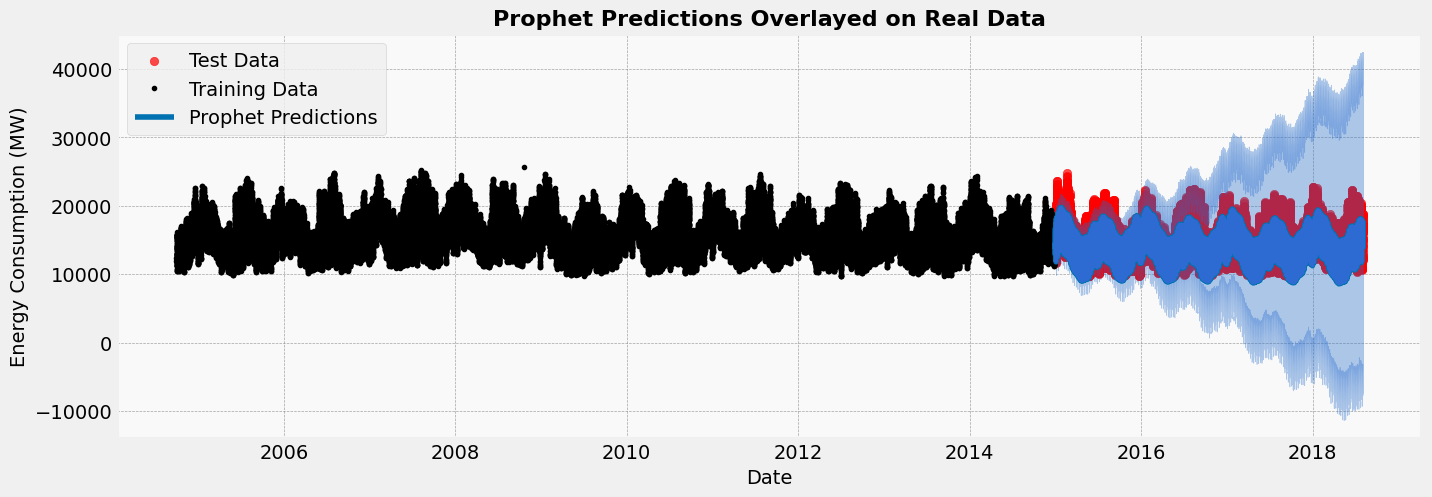

In [54]:
# Setting up the plot
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(test.index, test['AEP_MW'], color='red', alpha=0.7, label='Real Data')

fig = prophet_model.plot(prophet_fcst, ax=ax, plot_cap=False)

# Ploting prophet forecasts
ax.plot(prophet_fcst['ds'], prophet_fcst['yhat'], color='royalblue', linewidth=2.5, alpha=0.7, label='Prophet Predictions')
ax.fill_between(prophet_fcst['ds'], prophet_fcst['yhat_lower'], prophet_fcst['yhat_upper'], color='royalblue', alpha=0.2)
ax.set_title('Prophet Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area
plt.legend(['Test Data', 'Training Data', 'Prophet Predictions'], fontsize='medium', loc='upper left')

plt.show()

Prophet Model Error Metrics

In [56]:
prophet_MAE = mean_absolute_error(test['AEP_MW'], prophet_fcst['yhat']) # Changed 'PJME_MW' to 'AEP_MW' to match the actual column name in the 'test' DataFrame.
print(f'Mean Absolute Error Score on Test set: {prophet_MAE:0.2f}')

Mean Absolute Error Score on Test set: 1336.53


In [59]:
prophet_rmse = sqrt(mean_squared_error(test['AEP_MW'], prophet_fcst['yhat'])) # Changed 'PJME_MW' to 'AEP_MW' to match the actual column name in the 'test' DataFrame.
print(f'RMSE Score on Test set: {prophet_rmse:0.2f}')

RMSE Score on Test set: 1743.27


In [62]:
prophet_MAPE = mape(test['AEP_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Percent Error Score on Test set: {prophet_MAPE:0.2f}')

Mean Absolute Percent Error Score on Test set: 8.87
